In [9]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
# 1. 이미지 경로 및 레이블 리스트 생성
base_dir_original = 'Training'  # 데이터가 저장된 기본 경로
image_paths = []
labels = []

for folder_name in os.listdir(base_dir_original):
    folder_path = os.path.join(base_dir_original, folder_name)
    if os.path.isdir(folder_path):
        # 레이블 추출: 폴더 이름에서 정보 파싱
        label = folder_name.split(']')[-1].split('_')[0]
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if image_path.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(image_path)
                labels.append(label)


In [10]:
unique_labels = sorted(set(labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
labels = [label_to_index[label] for label in labels]

In [11]:
# train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# 3. 이미지 로드 및 전처리 함수 정의
def preprocess_image(image_path, label, target_height=200, target_width=200):
    # 이미지 읽기
    image = tf.io.read_file(image_path)
    # 이미지 디코딩 및 리사이징
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, target_height, target_width)
    # 픽셀 값을 0~1로 정규화
    image = image / 255.0
    return image, label

# 4. TensorFlow 데이터 파이프라인 생성
def create_dataset(image_paths, labels, batch_size=16, buffer_size=1000, target_height=200, target_width=200):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(
        lambda path, label: preprocess_image(path, label, target_height, target_width),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.shuffle(buffer_size=buffer_size)  # 버퍼 크기 설정
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


In [12]:
batch_size = 16
buffer_size = 1000  # 셔플 버퍼 크기 줄이기

train_dataset = create_dataset(train_paths, train_labels, batch_size=batch_size, buffer_size=buffer_size)
test_dataset = create_dataset(test_paths, test_labels, batch_size=batch_size, buffer_size=buffer_size)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model10 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(200, 200, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),  # 필터 수 감소
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),  # 뉴런 수 감소
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 추가
    tf.keras.layers.Dense(7, activation='softmax'),
])




In [14]:
# 모델 요약 출력
model10.summary()

# 모델 컴파일
model10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 99, 99, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 64)      

In [15]:
result9 = model10.fit(train_dataset, validation_data=test_dataset, epochs=50)

Epoch 1/50


2024-12-02 08:13:22.597292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-12-02 08:13:22.645373: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0xa1bd0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-02 08:13:22.645411: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-12-02 08:13:22.649681: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-02 08:13:22.763350: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


729/729 [==============================] - 90s 113ms/step - loss: 1.8893 - accuracy: 0.2349 - val_loss: 1.7491 - val_accuracy: 0.3086
Epoch 2/50
729/729 [==============================] - 79s 101ms/step - loss: 1.7721 - accuracy: 0.2952 - val_loss: 1.6638 - val_accuracy: 0.3416
Epoch 3/50
729/729 [==============================] - 79s 101ms/step - loss: 1.6992 - accuracy: 0.3214 - val_loss: 1.6450 - val_accuracy: 0.3546
Epoch 4/50
729/729 [==============================] - 79s 101ms/step - loss: 1.6301 - accuracy: 0.3530 - val_loss: 1.4902 - val_accuracy: 0.4198
Epoch 5/50
729/729 [==============================] - 79s 101ms/step - loss: 1.5658 - accuracy: 0.3882 - val_loss: 1.4285 - val_accuracy: 0.4578
Epoch 6/50
729/729 [==============================] - 79s 101ms/step - loss: 1.4916 - accuracy: 0.4267 - val_loss: 1.3657 - val_accuracy: 0.4763
Epoch 7/50
729/729 [==============================] - 79s 101ms/step - loss: 1.4204 - accuracy: 0.4533 - val_loss: 1.3498 - val_accuracy: 0.4

In [16]:
score10 = model10.evaluate(test_dataset)
score10 

183/183 [==============================] - 16s 57ms/step - loss: 2.9191 - accuracy: 0.5336


[2.91908597946167, 0.5336076617240906]

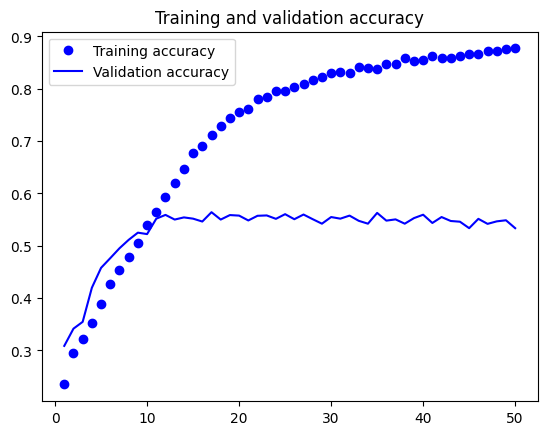

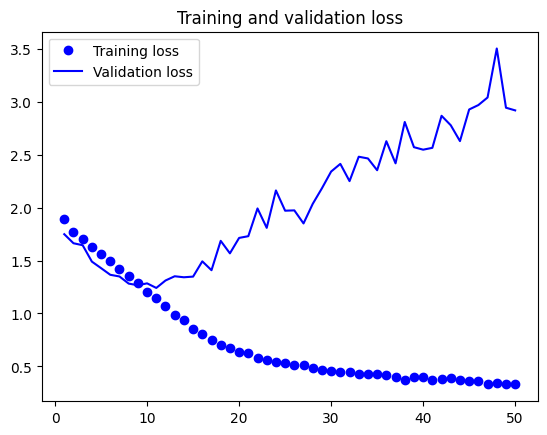

In [18]:
import matplotlib.pyplot as plt

acc10 = result9.history['accuracy']
val_acc10 = result9.history['val_accuracy']
loss10 = result9.history['loss']
val_loss10 = result9.history['val_loss']
epochs10 = range(1, len(acc10) + 1)

plt.plot(epochs10, acc10, 'bo', label='Training accuracy')
plt.plot(epochs10, val_acc10, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs10, loss10, 'bo', label='Training loss')
plt.plot(epochs10, val_loss10, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# # 그림에서도